In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import bayesnet as bn

np.random.seed(1234)

In [2]:
def create_toy_data(n=10):
    x = np.linspace(0, 1, n)[:, None]
    return x, np.sin(2 * np.pi * x) + np.random.normal(scale=0.25, size=(10, 1))
x_train, y_train = create_toy_data()

In [3]:
class NeuralNetwork(bn.Network):
    
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__(
            w1=np.random.randn(n_input, n_hidden),
            b1=np.zeros(n_hidden),
            w2=np.random.randn(n_hidden, n_output),
            b2=np.zeros(n_output)
        )

    def __call__(self, x, y=None):
        h = bn.tanh(x @ self.w1 + self.b1)
        mu = h @ self.w2 + self.b2
        self.y = bn.random.Gaussian(mu, 1., data=y)
        return mu

In [4]:
model = NeuralNetwork(1, 30, 1)
optimizer = bn.optimizer.Adam(model)

for _ in range(100000):
    model.cleargrad()
    model(x_train, y_train)
    loss = -model.elbo()
    loss.backward()
    optimizer.update()

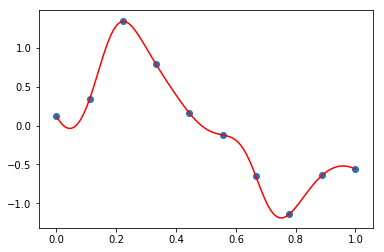

In [5]:
x = np.linspace(0, 1, 100)[:, None]
plt.scatter(x_train, y_train)
plt.plot(x, model(x).value, c="r")
plt.show()

In [6]:
class RegularizedNetwork(bn.Network):
    
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__(
            w1=np.random.randn(n_input, n_hidden),
            b1=np.zeros(n_hidden),
            w2=np.random.randn(n_hidden, n_output),
            b2=np.zeros(n_output)
        )

    def __call__(self, x, y=None):
        self.w1_prior = bn.random.Gaussian(np.zeros(self.w1.shape), 1, data=self.w1)
        self.b1_prior = bn.random.Gaussian(np.zeros(self.b1.shape), 1, data=self.b1)
        self.w2_prior = bn.random.Gaussian(np.zeros(self.w2.shape), 1, data=self.w2)
        self.b2_prior = bn.random.Gaussian(np.zeros(self.b2.shape), 1, data=self.b2)
        h = bn.tanh(x @ self.w1 + self.b1)
        mu = h @ self.w2 + self.b2
        self.y = bn.random.Gaussian(mu, 0.1, data=y)
        return mu

In [7]:
model = RegularizedNetwork(1, 30, 1)
optimizer = bn.optimizer.Adam(model)

for _ in range(100000):
    model.cleargrad()
    model(x_train, y_train)
    loss = -model.log_posterior()
    loss.backward()
    optimizer.update()

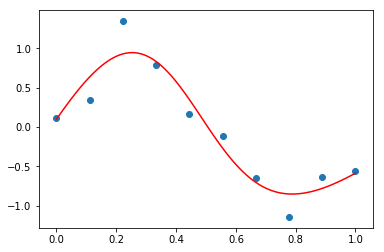

In [8]:
x = np.linspace(0, 1, 100)[:, None]
plt.scatter(x_train, y_train)
plt.plot(x, model(x).value, c="r")
plt.show()

In [9]:
class BayesianNetwork(bn.Network):
    
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__(
            w1_mu=np.zeros((n_input, n_hidden)),
            w1_logs=np.zeros((n_input, n_hidden)),
            b1_mu=np.zeros(n_hidden),
            b1_logs=np.zeros(n_hidden),
            w2_mu=np.zeros((n_hidden, n_output)),
            w2_logs=np.zeros((n_hidden, n_output)),
            b2_mu=np.zeros(n_output),
            b2_logs=np.zeros(n_output)
        )

    def __call__(self, x, y=None):
        self.w1 = bn.random.Gaussian(
            self.w1_mu, bn.exp(self.w1_logs),
            prior=bn.random.Gaussian(np.zeros(self.w1_mu.shape), np.ones(self.w1_mu.shape))
        )
        self.b1 = bn.random.Gaussian(
            self.b1_mu, bn.exp(self.b1_logs),
            prior=bn.random.Gaussian(np.zeros(self.b1_mu.shape), np.ones(self.b1_mu.shape))
        )
        self.w2 = bn.random.Gaussian(
            self.w2_mu, bn.exp(self.w2_logs),
            prior=bn.random.Gaussian(np.zeros(self.w2_mu.shape), np.ones(self.w2_mu.shape))
        )
        self.b2 = bn.random.Gaussian(
            self.b2_mu, bn.exp(self.b2_logs),
            prior=bn.random.Gaussian(np.zeros(self.b2_mu.shape), np.ones(self.b2_mu.shape))
        )
        h = bn.tanh(x @ self.w1.draw() + self.b1.draw())
        mu = h @ self.w2.draw() + self.b2.draw()
        self.y = bn.random.Gaussian(mu, 0.1, data=y)
        return mu

In [12]:
model = BayesianNetwork(1, 30, 1)
optimizer = bn.optimizer.Adam(model)
cost = []
for _ in range(100000):
    model.cleargrad()
    loss = 0
    for _ in range(3):
        model(x_train, y_train)
        loss -= model.elbo() / 3
    loss.backward()
    optimizer.update()
    cost.append(loss.value)

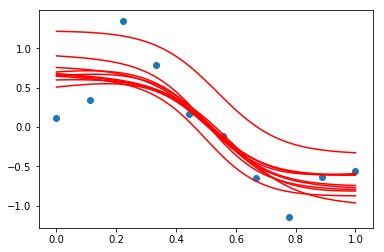

In [15]:
x = np.linspace(0, 1, 100)[:, None]
plt.scatter(x_train, y_train)
for _ in range(10):
    plt.plot(x, model(x).value, c="r")
plt.show()